# 0. Getting Setup

Let's get started by importing/downloading the required libraries and setting up our environment.

In [1]:
class bcolors():
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [3]:
# regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't exist
try:
    from torchinfo import summary
except:
    print(f"{bcolors.WARNING}torchinfo not found, installing torchinfo{bcolors.ENDC}")
    !pip3 install torchinfo
    from torchinfo import summary
    
# Try to import the going_modular directory, download it if it doesn't exist
try:
    from going_modular import data_setup, engine
    
except:
    # Get the going_modular scripts
    print(f"{bcolors.WARNING}going_modular not found, cloning going_modular{bcolors.ENDC}")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine 

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{bcolors.OKBLUE}Using {device} device{bcolors.ENDC}")

Using cpu device


# 1. Get data

Before we can start to use transfer learning. we'll need a dataset.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{bcolors.OKGREEN}{image_path} directory already exists, data is already prepared{bcolors.ENDC}")
else:
    print(f"{bcolors.WARNING}{image_path} directory does not exist, downloading and preparing data...{bcolors.ENDC}")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"{bcolors.OKBLUE}Downloading pizza, steak, sushi data...{bcolors.ENDC}")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"{bcolors.OKBLUE}Unzipping pizza, steak, sushi data...{bcolors.ENDC}")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory already exists, data is already prepared


# 2. Create Datasets and DataLoaders

we will use our previously created data_setup.py script to instantiate.

## 2.1 Creating a transform for torchvision.models (manual creation)

In [6]:
# previously we need to read documentation from models image transformations.

# Define image transformations
manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# New way to get the transformation
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
weights = EfficientNet_B0_Weights.DEFAULT

preprocess = weights.transforms()
preprocess, manual_transform

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
# Create training and testing DataLoaders as well as get a list of class namees
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(
    train_dir = train_dir,
    test_dir = test_dir,
    test_transform = manual_transform,
    train_transform = manual_transform,
    batch_size = 32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f695754770>,
 ['pizza', 'steak', 'sushi'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


images.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


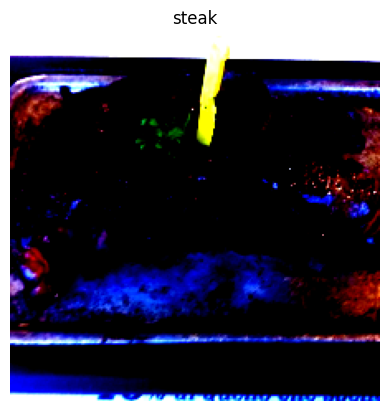

In [9]:
for images, labels in train_dataloader:
    print(f"images.shape: {images.shape}")
    print(f"labels.shape: {labels.shape}")
    plt.imshow(images[0].permute(1,2,0))
    plt.title(class_names[labels[0]])
    plt.axis("off")
    plt.show()
    break

## 2.2 Creating a transform for `torchvision.models` (auto creation)

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create training and testing DataLoaders using the auto_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(
    train_dir = train_dir,
    test_dir = test_dir,
    train_transform = auto_transforms,
    test_transform = auto_transforms,
    batch_size = 32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f695824230>,
 ['pizza', 'steak', 'sushi'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


images.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


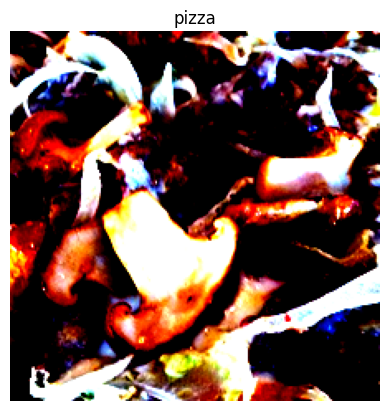

In [13]:
for images, labels in train_dataloader:
    print(f"images.shape: {images.shape}")
    print(f"labels.shape: {labels.shape}")
    plt.imshow(images[0].permute(1,2,0))
    plt.title(class_names[labels[0]])
    plt.axis("off")
    plt.show()
    break


# 3. Getting a pretrained model

## 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

You might think better performance is always better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, as The Bitter Lesson states, you'd likely take the biggest, most compute hungry model you can.

Understanding this performance vs. speed vs. size tradeoff will come with time and practice.

For me, I've found a nice balance in the efficientnet_bX models.

## 3.2 Setting up a pretrained modeel

The pretrained model we're going to be using is `torchvision.models.efficientnet_b0()`.

In [14]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model # uncomment to output (it's very long)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with `torchinfo.summary()`


In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(
    model=model,
    input_size=(32,3,224,224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretraind model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

Note: To freeze layers means to keep them how they are during training. For example, if your model has pretrained layers, to freeze them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers

In [16]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Let's change the classifier section of the model (the top of the model) to have an output size of 3 (pizza, steak, sushi)

# Set the manual_seed
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Get the lenght of the class_names (number of classes)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [18]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train model

Now we've got a pretrained model that's semi-frozen and has a customised `classifier`, how about we see transfer learning in action?

In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# we will you our `train()` function we defined in the `engine.py` script to train our model
# Note: we're only going to be training the parameters `classifier` here as all the other parameters in our model have been frozen.

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=50,
    device=device
)

# End the timer and print out how long it took
end_time = timer()
print(f"{bcolors.OKGREEN}Time taken: {end_time - start_time:.3f} seconds{bcolors.ENDC}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4524 | train_acc: 0.8125 | test_loss: 0.4192 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.3995 | train_acc: 0.9531 | test_loss: 0.4328 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.3926 | train_acc: 0.9688 | test_loss: 0.4884 | test_acc: 0.7964
Epoch: 4 | train_loss: 0.4136 | train_acc: 0.8320 | test_loss: 0.3845 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.3527 | train_acc: 0.9648 | test_loss: 0.4012 | test_acc: 0.9271
Epoch: 6 | train_loss: 0.3492 | train_acc: 0.9492 | test_loss: 0.4103 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.3047 | train_acc: 0.9492 | test_loss: 0.3299 | test_acc: 0.9271


KeyboardInterrupt: 

# 5. Evaluate model by plotting loss curves


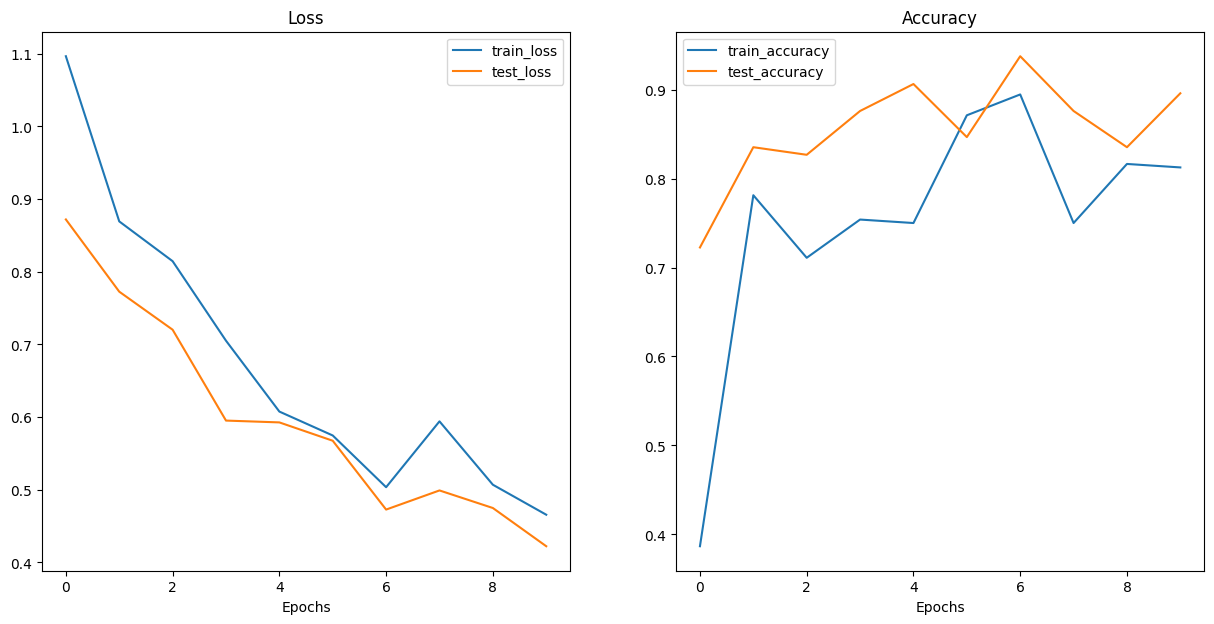

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from utils import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Make predictions on images from the test set

In [25]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

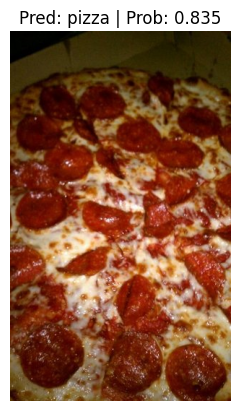

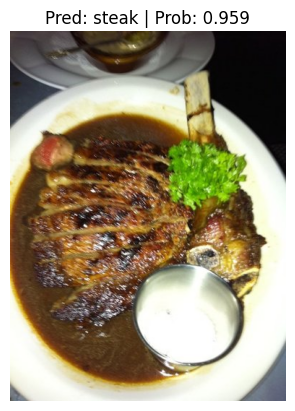

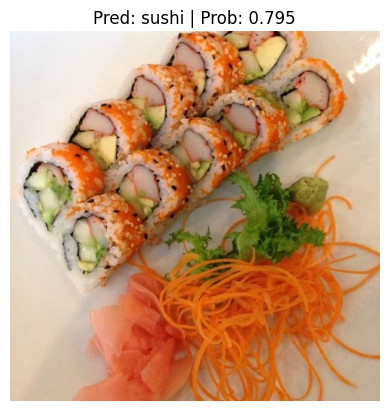

In [26]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

Custom image already exists...


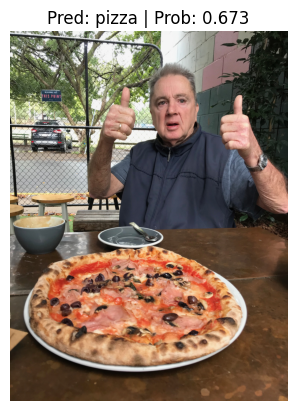

In [29]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"{bcolors.OKBLUE}Downloading custom image...{bcolors.ENDC}")
        f.write(request.content)
else:
    print(f"{bcolors.OKGREEN}Custom image already exists...{bcolors.ENDC}")
    
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)